In [213]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import *
from collections import Counter
import pickle as pkl
import gradio as gr

# ========== LOAD DATA ==========

In [75]:
fpaData = pd.read_csv("flood_data_10_years.csv")
fpaData

,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1/4/2015,Short Dry Season,lowland,False,False,False,False,False,17.5,1.08,43.4,26.0,54.1,8.4,1009.1,0.285,0,-2.562914,29.275357
1,1/4/2015,Short Dry Season,lowland,False,False,False,False,True,0.4,0.65,26.2,23.9,42.9,5.8,1019.3,0.138,0,-2.562914,29.275357
2,1/4/2015,Short Dry Season,lowland,False,False,False,True,False,11.6,0.52,38.6,21.5,51.0,12.8,1013.5,0.223,0,-2.562914,29.275357
3,1/4/2015,Short Dry Season,lowland,False,False,False,True,True,4.4,0.56,36.4,19.3,53.9,4.1,1005.4,0.217,0,-2.562914,29.275357
4,1/4/2015,Short Dry Season,lowland,False,False,True,False,False,18.6,0.90,39.0,18.3,65.5,8.4,1005.3,0.308,0,-2.562914,29.275357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350395,12/31/2024,Short Dry Season,upland,True,True,False,True,True,4.2,0.53,31.5,24.1,56.2,8.1,1013.1,0.335,0,-1.008440,30.867486
350396,12/31/2024,Short Dry Season,upland,True,True,True,False,False,2.7,0.58,26.6,26.5,50.6,11.9,1008.6,0.292,0,-1.008440,30.867486
350397,12/31/2024,Short Dry Season,upland,True,True,True,False,True,21.7,1.00,46.2,20.2,67.9,14.3,1011.7,0.501,1,-1.008440,30.867486
350398,12/31/2024,Short Dry Season,upland,True,True,True,True,False,4.0,0.77,28.5,21.6,54.4,10.9,1007.2,0.356,0,-1.008440,30.867486


In [77]:
print(fpaData.columns.tolist())

['date', 'season', 'location_type', 'has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested', 'rainfall_mm', 'water_level_m', 'soil_moisture', 'temp_c', 'humidity', 'wind_speed', 'pressure', 'flood_probability', 'flood', 'latitude', 'longitude']


# ========== ENCODE season and location_type AS INTEGERS ==========

In [80]:
# Strip leading/trailing spaces
fpaData['season'] = fpaData['season'].str.strip()
fpaData['location_type'] = fpaData['location_type'].str.strip()

In [82]:
# 2. Encode season and location_type
season_mapping = {
    "Long Rainy Season": 1,
    "Short Rainy Season": 2,
    "Long Dry Season": 3,
    "Short Dry Season": 4
}
location_mapping = {
    "lowland": 1,
    "middleland": 2,
    "upland": 3
}

fpaData['season'] = fpaData['season'].map(season_mapping)
fpaData['location_type'] = fpaData['location_type'].map(location_mapping)
# ✅ Validate mappings
if fpaData['season'].isnull().any():
    print("⚠️ Some season values failed to map!")

if fpaData['location_type'].isnull().any():
    print("⚠️ Some location_type values failed to map!")
fpaData

,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1/4/2015,4,1,False,False,False,False,False,17.5,1.08,43.4,26.0,54.1,8.4,1009.1,0.285,0,-2.562914,29.275357
1,1/4/2015,4,1,False,False,False,False,True,0.4,0.65,26.2,23.9,42.9,5.8,1019.3,0.138,0,-2.562914,29.275357
2,1/4/2015,4,1,False,False,False,True,False,11.6,0.52,38.6,21.5,51.0,12.8,1013.5,0.223,0,-2.562914,29.275357
3,1/4/2015,4,1,False,False,False,True,True,4.4,0.56,36.4,19.3,53.9,4.1,1005.4,0.217,0,-2.562914,29.275357
4,1/4/2015,4,1,False,False,True,False,False,18.6,0.90,39.0,18.3,65.5,8.4,1005.3,0.308,0,-2.562914,29.275357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350395,12/31/2024,4,3,True,True,False,True,True,4.2,0.53,31.5,24.1,56.2,8.1,1013.1,0.335,0,-1.008440,30.867486
350396,12/31/2024,4,3,True,True,True,False,False,2.7,0.58,26.6,26.5,50.6,11.9,1008.6,0.292,0,-1.008440,30.867486
350397,12/31/2024,4,3,True,True,True,False,True,21.7,1.00,46.2,20.2,67.9,14.3,1011.7,0.501,1,-1.008440,30.867486
350398,12/31/2024,4,3,True,True,True,True,False,4.0,0.77,28.5,21.6,54.4,10.9,1007.2,0.356,0,-1.008440,30.867486


In [84]:
# 3. Convert boolean features to integers
bool_cols = ['has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested']
for col in bool_cols:
    fpaData[col] = fpaData[col].astype(int)

fpaData

,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1/4/2015,4,1,0,0,0,0,0,17.5,1.08,43.4,26.0,54.1,8.4,1009.1,0.285,0,-2.562914,29.275357
1,1/4/2015,4,1,0,0,0,0,1,0.4,0.65,26.2,23.9,42.9,5.8,1019.3,0.138,0,-2.562914,29.275357
2,1/4/2015,4,1,0,0,0,1,0,11.6,0.52,38.6,21.5,51.0,12.8,1013.5,0.223,0,-2.562914,29.275357
3,1/4/2015,4,1,0,0,0,1,1,4.4,0.56,36.4,19.3,53.9,4.1,1005.4,0.217,0,-2.562914,29.275357
4,1/4/2015,4,1,0,0,1,0,0,18.6,0.90,39.0,18.3,65.5,8.4,1005.3,0.308,0,-2.562914,29.275357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350395,12/31/2024,4,3,1,1,0,1,1,4.2,0.53,31.5,24.1,56.2,8.1,1013.1,0.335,0,-1.008440,30.867486
350396,12/31/2024,4,3,1,1,1,0,0,2.7,0.58,26.6,26.5,50.6,11.9,1008.6,0.292,0,-1.008440,30.867486
350397,12/31/2024,4,3,1,1,1,0,1,21.7,1.00,46.2,20.2,67.9,14.3,1011.7,0.501,1,-1.008440,30.867486
350398,12/31/2024,4,3,1,1,1,1,0,4.0,0.77,28.5,21.6,54.4,10.9,1007.2,0.356,0,-1.008440,30.867486


# Exploratory Data Analysis

# ========== SELECT FEATURES AND TARGET ==========

In [88]:
# 4. Select features and target
features = [
    'rainfall_mm', 'water_level_m', 'soil_moisture', 'temp_c', 'humidity',
    'wind_speed', 'pressure',
    'has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested',
    'season', 'location_type'
]
target = 'flood'

X = fpaData[features]
y = fpaData[target]

In [90]:
X

,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,season,location_type
0,17.5,1.08,43.4,26.0,54.1,8.4,1009.1,0,0,0,0,0,4,1
1,0.4,0.65,26.2,23.9,42.9,5.8,1019.3,0,0,0,0,1,4,1
2,11.6,0.52,38.6,21.5,51.0,12.8,1013.5,0,0,0,1,0,4,1
3,4.4,0.56,36.4,19.3,53.9,4.1,1005.4,0,0,0,1,1,4,1
4,18.6,0.90,39.0,18.3,65.5,8.4,1005.3,0,0,1,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350395,4.2,0.53,31.5,24.1,56.2,8.1,1013.1,1,1,0,1,1,4,3
350396,2.7,0.58,26.6,26.5,50.6,11.9,1008.6,1,1,1,0,0,4,3
350397,21.7,1.00,46.2,20.2,67.9,14.3,1011.7,1,1,1,0,1,4,3
350398,4.0,0.77,28.5,21.6,54.4,10.9,1007.2,1,1,1,1,0,4,3


# ========== SPLIT DATA ==========

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ========== Train models ==========

In [96]:
X_train

,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,season,location_type
36046,8.2,0.50,42.6,21.9,65.1,11.9,1009.0,0,1,1,1,0,4,2
247114,7.4,0.64,34.7,24.5,58.1,11.7,1017.9,0,1,0,1,0,4,1
323220,6.7,0.42,43.9,28.3,55.7,7.2,998.5,1,0,1,0,0,1,3
305423,4.4,0.60,33.7,24.2,45.9,10.0,1013.6,0,1,1,1,1,2,2
40874,10.6,0.57,33.6,21.7,53.1,15.0,1010.0,0,1,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,3.9,0.60,36.8,26.9,49.1,14.5,1009.0,0,0,1,1,1,3,3
259178,16.8,0.78,40.0,28.1,37.8,13.2,1010.4,0,1,0,1,0,1,3
131932,24.0,1.13,39.8,19.3,66.0,10.6,1009.9,1,1,1,0,0,2,1
146867,5.4,0.57,37.1,27.3,60.6,6.3,1018.6,1,0,0,1,1,1,3


### ========== MODEL 1: Random Forest ==========

In [146]:
randomModel = RandomForestClassifier(n_estimators=100, random_state=42)
randomModel.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [100]:
# Predict probabilities and classes
y_proba = randomModel.predict_proba(X_test)[:, 1]  # Probability of flood = 1
randomModel_pred = (y_proba > 0.5).astype(int)         # Convert to class

In [101]:
# Evaluate using accuracy, precision, recall, Support and F1-score.
randomModelAccuracy = accuracy_score(y_test, randomModel_pred)
randomModelPrecision = precision_score(y_test, randomModel_pred,average='macro')
randomModelRecall = recall_score(y_test, randomModel_pred, average='macro')
randomModelF1 = f1_score(y_test, randomModel_pred, average='macro')
print("📊 Random Forest Model Evaluation Metrics")
print("randomModel Accuracy: ", randomModelAccuracy)
print("randomModel Precision: ", randomModelPrecision)
print("randomModel Recall: ", randomModelRecall)
print("randomModel F1 Score: ", randomModelF1)

📊 Random Forest Model Evaluation Metrics
randomModel Accuracy:  0.9866010273972603
randomModel Precision:  0.9864767637079186
randomModel Recall:  0.9858939252967394
randomModel F1 Score:  0.9861823351385154


In [102]:
# Display and interpret the confusion matrix
report = classification_report(y_test, randomModel_pred)
cm = confusion_matrix(y_test, randomModel_pred)

print("\nrandomModel Classification Report:\n", report)
print("randomModel Confusion Matrix:\n", cm)


randomModel Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     41081
           1       0.99      0.98      0.98     28999

    accuracy                           0.99     70080
   macro avg       0.99      0.99      0.99     70080
weighted avg       0.99      0.99      0.99     70080

randomModel Confusion Matrix:
 [[40670   411]
 [  528 28471]]


In [103]:
# 9. Categorize risk based on probability
def categorize_risk(prob):
    if prob < 0.3:
        return "Low"
    elif prob < 0.6:
        return "Moderate"
    elif prob < 0.85:
        return "High"
    else:
        return "Severe"

risk_categories = [categorize_risk(p) for p in y_proba]
risk_categories

['Severe',
 'Severe',
 'High',
 'Low',
 'Low',
 'Moderate',
 'Severe',
 'Low',
 'Low',
 'Low',
 'Low',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Low',
 'Severe',
 'Low',
 'Severe',
 'Low',
 'Severe',
 'Low',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Low',
 'Low',
 'Low',
 'Severe',
 'Low',
 'Low',
 'Low',
 'Severe',
 'Low',
 'Low',
 'Severe',
 'Low',
 'Moderate',
 'Low',
 'Moderate',
 'Low',
 'Severe',
 'Severe',
 'Low',
 'Low',
 'Severe',
 'Severe',
 'Low',
 'Severe',
 'Low',
 'Severe',
 'Low',
 'Low',
 'Low',
 'Severe',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Severe',
 'Severe',
 'Severe',
 'Low',
 'Low',
 'Severe',
 'Severe',
 'Low',
 'Severe',
 'Low',
 'Low',
 'Low',
 'Low',
 'Severe',
 'Severe',
 'Low',
 'Severe',
 'Severe',
 'Severe',
 'Low',
 'Low',
 'Low',
 'Severe',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Severe',
 'Severe',
 'Low',
 'Severe',
 'Low',
 'Low',
 'Moderate',
 'Severe',
 'Severe',
 'Low',
 'Low',


### ========== MODEL 2: KNN ==========

In [105]:
kModel = KNeighborsClassifier(n_neighbors=5)
kModel.fit(X_train, y_train)

KNeighborsClassifier()

In [145]:
# Predict class labels for test set
kModel_pred = kModel.predict(X_test)
# Predict probabilities for flood class (1)
kModel_proba = kModel.predict_proba(X_test)[:, 1]

In [107]:
# Evaluation metrics
kModelAccuracy = accuracy_score(y_test, kModel_pred)
kModelPrecision = precision_score(y_test, kModel_pred, average='macro')
kModelRecall = recall_score(y_test, kModel_pred, average='macro')
kModelF1_Score = f1_score(y_test, kModel_pred, average='macro')

print("📊 KNN Model Evaluation Metrics")
print("✅ KNN Model Accuracy       :", round(kModelAccuracy, 4))
print("🎯 KNN Model Precision (macro):", round(kModelPrecision, 4))
print("🔁 KNN Model Recall (macro)   :", round(kModelRecall, 4))
print("📈 KNN Model F1 Score (macro) :", round(kModelF1_Score, 4))

# Risk category distribution
knn_risk_categories = [categorize_risk(p) for p in kModel.predict_proba(X_test)[:, 1]]
risk_counts = Counter(knn_risk_categories)
print("\n📊 KNN Flood Risk Category Counts:")
for category, count in risk_counts.items():
    print(f"{category}: {count}")


📊 KNN Model Evaluation Metrics
✅ KNN Model Accuracy       : 0.8427
🎯 KNN Model Precision (macro): 0.8406
🔁 KNN Model Recall (macro)   : 0.8331
📈 KNN Model F1 Score (macro) : 0.8362

📊 KNN Flood Risk Category Counts:
Moderate: 8032
High: 13336
Low: 34926
Severe: 13786


In [108]:
# Classification report
report = classification_report(y_test, kModel_pred, digits=4)
print("\n📋 KNN Model Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, kModel_pred)
print("📊 KNN Model Confusion Matrix:\n", cm)


📋 KNN Model Classification Report:
               precision    recall  f1-score   support

           0     0.8498    0.8887    0.8688     41081
           1     0.8314    0.7775    0.8035     28999

    accuracy                         0.8427     70080
   macro avg     0.8406    0.8331    0.8362     70080
weighted avg     0.8422    0.8427    0.8418     70080

📊 KNN Model Confusion Matrix:
 [[36507  4574]
 [ 6451 22548]]


### ========== MODEL 3: SVM ==========

In [147]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 1.5 MB/s eta 0:01:43
   ---------------------------------------- 1.3/150.0 MB 1.9 MB/s eta 0:01:18
    --------------------------------------- 2.1/150.0 MB 2.4 MB/s eta 0:01:01
    --------------------------------------- 3.1/150.0 MB 2.9 MB/s eta 0:00:51
   - -------------------------------------- 3.9/150.0 MB 3.2 MB/s eta 0:00:47
   - -------------------------------------- 5.0/150.0 MB 3.4 MB/s eta 0:00:44
   - -------------------------------------- 5.8/150.0 MB 3.5 MB/s eta 0:00:42
   - -------------------------------------- 6.8/150.0 MB 3.6 MB/s eta 0:00:40
   -- ---------------

In [215]:
# Train the XGBoost model (DMatrix not needed for sklearn API)
XGBModel = XGBClassifier(random_state=42)
XGBModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [217]:
# Evaluation Metrics
XGBModelAccuracy = accuracy_score(y_test, XGBModel_pred)
XGBModelPrecision = precision_score(y_test, XGBModel_pred, average='macro')
XGBModelRecall = recall_score(y_test, XGBModel_pred, average='macro')
XGBModelF1_Score = f1_score(y_test, XGBModel_pred, average='macro')

print("📊 XGBoost Model Evaluation Metrics")
print("✅ Accuracy         :", round(XGBModelAccuracy, 4))
print("🎯 Precision (macro):", round(XGBModelPrecision, 4))
print("🔁 Recall (macro)   :", round(XGBModelRecall, 4))
print("📈 F1 Score (macro) :", round(XGBModelF1_Score, 4))

# Optional: Risk category distribution (if binary classification)
try:
    xgb_y_proba = xgb_model.predict_proba(X_test)[:, 1]
    def categorize_risk(p):
        if p >= 0.8:
            return "🚨 High"
        elif p >= 0.5:
            return "⚠️ Medium"
        else:
            return "✅ Low"

    xgb_risk_categories = [categorize_risk(p) for p in xgb_y_proba]
    risk_counts = Counter(xgb_risk_categories)
    print("\n📊 XGBoost Flood Risk Category Counts:")
    for category, count in risk_counts.items():
        print(f"{category}: {count}")
except AttributeError:
    print("\n⚠️ XGBoost model does not support predict_proba or encountered an error.")

📊 XGBoost Model Evaluation Metrics
✅ Accuracy         : 0.9938
🎯 Precision (macro): 0.9936
🔁 Recall (macro)   : 0.9936
📈 F1 Score (macro) : 0.9936

📊 XGBoost Flood Risk Category Counts:
🚨 High: 27735
⚠️ Medium: 1264
✅ Low: 41081


In [219]:
# Generate classification report
xgb_report = classification_report(y_test, XGBModel_pred, digits=4)
print("\n📋 XGBoost Model Classification Report:\n", xgb_report)

# Generate confusion matrix
xgb_cm = confusion_matrix(y_test, XGBModel_pred)
print("📊 XGBoost Model Confusion Matrix:\n", xgb_cm)


📋 XGBoost Model Classification Report:
               precision    recall  f1-score   support

           0     0.9947    0.9947    0.9947     41081
           1     0.9925    0.9925    0.9925     28999

    accuracy                         0.9938     70080
   macro avg     0.9936    0.9936    0.9936     70080
weighted avg     0.9938    0.9938    0.9938     70080

📊 XGBoost Model Confusion Matrix:
 [[40863   218]
 [  218 28781]]


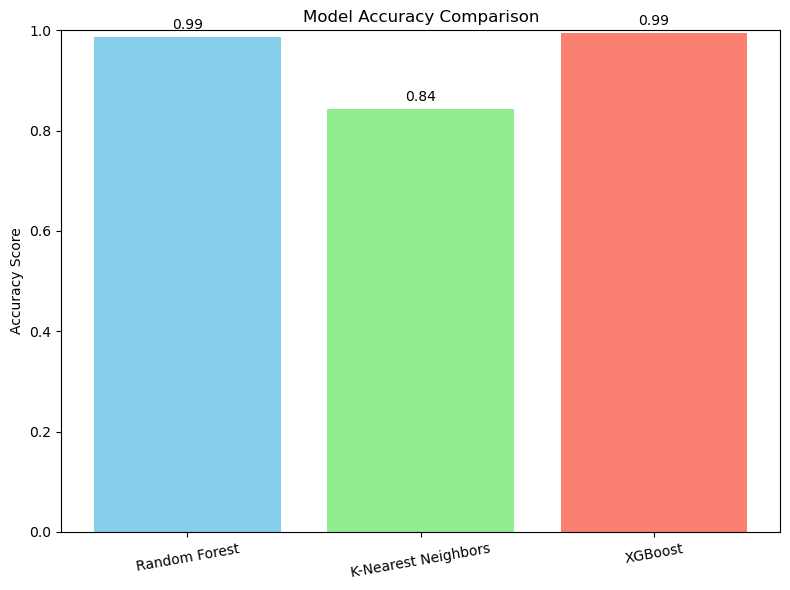

In [221]:
# Accuracy dictionary
modelAccuracies = {
    "Random Forest": randomModelAccuracy,
    "K-Nearest Neighbors": kModelAccuracy,
    "XGBoost": XGBModelAccuracy
}

# Color palette (ensure enough colors)
colors = ['skyblue', 'lightgreen', 'salmon']

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(modelAccuracies.keys(), modelAccuracies.values(), color=colors)

# Titles and labels
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.xticks(rotation=10)

# Annotate each bar with accuracy
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

# Save figure
plt.tight_layout()
plt.savefig("Model_Accuracy_Comparison.png", dpi=300)
plt.show()

In [222]:
print(fpaData.columns.tolist())


['date', 'season', 'location_type', 'has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested', 'rainfall_mm', 'water_level_m', 'soil_moisture', 'temp_c', 'humidity', 'wind_speed', 'pressure', 'flood_probability', 'flood', 'latitude', 'longitude']


In [225]:
pkl.dump(randomModel, open('randomModel_flood_prediction_model.pkl', 'wb'))

In [227]:
pkl.dump(kModel, open('kModel_flood_prediction_model.pkl', 'wb'))

In [229]:
pkl.dump(XGBModel, open('XGBModel_flood_prediction_model.pkl', 'wb'))

In [231]:
randomModel = pkl.load(open('randomModel_flood_prediction_model.pkl', 'rb'))

In [232]:
XGBModel = pkl.load(open('XGBModel_flood_prediction_model.pkl', 'rb'))

In [234]:
kModel = pkl.load(open('kModel_flood_prediction_model.pkl', 'rb'))


In [237]:
randomModel

RandomForestClassifier(random_state=42)

In [239]:
kModel

KNeighborsClassifier()

In [241]:
XGBModel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [243]:
print(fpaData.columns)

Index(['date', 'season', 'location_type', 'has_river', 'has_lake',
       'has_poor_drainage', 'is_urban', 'is_deforested', 'rainfall_mm',
       'water_level_m', 'soil_moisture', 'temp_c', 'humidity', 'wind_speed',
       'pressure', 'flood_probability', 'flood', 'latitude', 'longitude'],
      dtype='object')


In [245]:
import pandas as pd
import pickle as pkl
import gradio as gr

# ======= Load Models =========
randomModel = pkl.load(open('randomModel_flood_prediction_model.pkl', 'rb'))
kModel = pkl.load(open('kModel_flood_prediction_model.pkl', 'rb'))
xgbModel = pkl.load(open('xgbModel_flood_prediction_model.pkl', 'rb'))

# Expected input columns (season and location_type encoded as integers)
expected_features = [
    'rainfall_mm', 'water_level_m', 'soil_moisture', 'temp_c', 'humidity',
    'wind_speed', 'pressure', 'has_river', 'has_lake', 'has_poor_drainage',
    'is_urban', 'is_deforested', 'season', 'location_type'
]

# Mappings for season and location_type
season_mapping = {
    "Long Rainy Season": 1,
    "Short Rainy Season": 2,
    "Long Dry Season": 3,
    "Short Dry Season": 4
}
location_mapping = {
    "lowland": 1,
    "middleland": 2,
    "upland": 3
}

# Risk categorization helper
def categorize_risk(prob):
    if prob >= 0.8:
        return "🚨 High Flood Risk"
    elif prob >= 0.5:
        return "⚠️ Medium Flood Risk"
    else:
        return "✅ Low Flood Risk"

# ========== Prediction Function ==========
def predict_flood(rainfall_mm, water_level_m, soil_moisture, temp_c, humidity,
                  wind_speed, pressure, has_river, has_lake, has_poor_drainage,
                  is_urban, is_deforested, season, location_type, model_name):
    
    # Encode season and location_type
    season_encoded = season_mapping.get(season, 0)
    location_encoded = location_mapping.get(location_type, 0)

    # Prepare input data dict
    input_data = {
        'rainfall_mm': rainfall_mm,
        'water_level_m': water_level_m,
        'soil_moisture': soil_moisture,
        'temp_c': temp_c,
        'humidity': humidity,
        'wind_speed': wind_speed,
        'pressure': pressure,
        'has_river': int(has_river),
        'has_lake': int(has_lake),
        'has_poor_drainage': int(has_poor_drainage),
        'is_urban': int(is_urban),
        'is_deforested': int(is_deforested),
        'season': season_encoded,
        'location_type': location_encoded
    }

    df = pd.DataFrame([input_data])[expected_features]

    # Select model
    if model_name == "Random Forest":
        model = randomModel
    elif model_name == "KNN":
        model = kModel
    elif model_name == "XGBoost":
        model = xgbModel
    else:
        return "❌ Invalid Model Selected", "N/A"

    # Predict flood class and probability
    prediction = model.predict(df)[0]
    try:
        prob = model.predict_proba(df)[0][1]
    except AttributeError:
        prob = None

    if prob is not None and isinstance(prob, float):
        risk_label = categorize_risk(prob)
        prob_str = f"{prob:.4f}"
    else:
        risk_label = "Risk level unavailable"
        prob_str = "N/A"

    return risk_label, prob_str

# ========== Gradio Interface ==========
interface = gr.Interface(
    fn=predict_flood,
    inputs=[
        gr.Number(label="Rainfall (mm)"),
        gr.Number(label="Water Level (m)"),
        gr.Number(label="Soil Moisture"),
        gr.Number(label="Temperature (°C)"),
        gr.Number(label="Humidity (%)"),
        gr.Number(label="Wind Speed"),
        gr.Number(label="Pressure"),
        gr.Checkbox(label="Has River"),
        gr.Checkbox(label="Has Lake"),
        gr.Checkbox(label="Has Poor Drainage"),
        gr.Checkbox(label="Is Urban"),
        gr.Checkbox(label="Is Deforested"),
        gr.Radio(
            ["Long Rainy Season", "Short Rainy Season", "Long Dry Season", "Short Dry Season"],
            label="Season"
        ),
        gr.Radio(["lowland", "middleland", "upland"], label="Location Type"),
        gr.Radio(["Random Forest", "KNN", "XGBoost"], label="Model to Use")
    ],
    outputs=[
        gr.Label(label="Flood Risk Level"),
        gr.Textbox(label="Flood Probability")
    ],
    title="🌧️ Flood Prediction System",
    description="Input environmental conditions and choose a model to predict flood risk level and probability."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.
